# Download and process ratings data

In [1]:
import pandas as pd
import gzip
import numpy as np
from sklearn import metrics, preprocessing
from sklearn.model_selection import cross_validate

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

ratings = getDF('reviews_Beauty_5.json.gz')

In [3]:
ratings.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013"


In [4]:
ratings.rename(columns={'reviewerID': 'user_id', 
                        'asin': 'item_id', 
                        'reviewerName': 'user_name', 
                        'reviewText': 'review_text',
                        'summary': 'review_summary',
                        'overall': 'score'},
               inplace=True)

In [5]:
ratings.user_id = ratings.user_id.astype('category').cat.codes.values
ratings.item_id = ratings.item_id.astype('category').cat.codes.values
# Add IDs for embeddings.
ratings['user_emb_id'] = ratings['user_id']
ratings['item_emb_id'] = ratings['item_id']

In [6]:
ratings.head()

,user_id,item_id,user_name,helpful,review_text,score,review_summary,unixReviewTime,reviewTime,user_emb_id,item_emb_id
0,5584,0,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014",5584,0
1,17504,0,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014",17504,0
2,14499,0,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013",14499,0
3,4157,0,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013",4157,0
4,13219,0,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013",13219,0


In [7]:
ratings.info

<bound method DataFrame.info of         user_id  item_id                                         user_name  \
0          5584        0                                            Andrea   
1         17504        0                                        Jessica H.   
2         14499        0                                             Karen   
3          4157        0                                             Norah   
4         13219        0                                         Nova Amor   
5         13792        0                    S. M. Randall "WildHorseWoman"   
6          5704        0                                 tasha "luvely12b"   
7         21852        0                                     TreMagnifique   
8         15399        1                                               NaN   
9         11934        1                               Amina Bint Ibraheem   
10        20678        1                                           Charmmy   
11        14368        1        

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
items_reviews = ratings.item_id.value_counts()
plt.figure(figsize=(20,8))
sns.barplot(x = items_reviews[:24].index, y = items_reviews[:24].values)
plt.title('histogram of Categories')

Text(0.5, 1.0, 'histogram of Categories')

# Text embeddings and classifier

In [9]:
!pip install spacy

In [10]:
# python -m spacy download en

In [11]:
import spacy

nlp_en = spacy.load('en', vectors='en_glove_cc_300_1m')
example_reviews = ['this creme is amazing', 'creme amazing', 'this shoe does not fit; it hurts', 'shoe hurts']
example_embs = np.vstack([nlp_en(e).vector for e in example_reviews])
sklearn.metrics.pairwise.cosine_similarity(example_embs)

df = ratings[['review_summary']]
summary_embs = np.vstack([nlp_en(e).vector for e in df])

summary_embs

In [12]:
#Classification

from sklearn.model_selection import train_test_split
x = ratings[['score']], 
y= summary_embs
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state= 50)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
import sys

df = KNeighborsClassifier(n_neighbors = )
cv_results = cross_validate(y, X_train, y_train, cv=10, scoring='roc_auc',return_train_score=False)

# Recommender system

In [14]:
import keras as ks
from tensorrec import TensorRec
from tensorrec.representation_graphs import AbstractKerasRepresentationGraph

Using TensorFlow backend.


In [15]:
class DeepRepresentationGraph(AbstractKerasRepresentationGraph):
    def create_layers(self, n_features, n_components):
        return [
            ks.layers.Dense(n_components * 16, activation='relu'),
            ks.layers.Dense(n_components * 8, activation='relu'),
            ks.layers.Dense(n_components * 2, activation='relu'),
            ks.layers.Dense(n_components, activation='tanh'),
        ]

In [16]:
# My new recommender system with two deep nets
model = TensorRec(item_repr_graph=DeepRepresentationGraph(),
                  user_repr_graph=DeepRepresentationGraph())

# Wordcloud

In [17]:
!pip install wordcloud
!pip install matplotlib
!pip install Pillow

In [18]:
from wordcloud import WordCloud
import PIL
import itertools
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

In [19]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["the", "of", "a", "an", "and","about","may","might"])

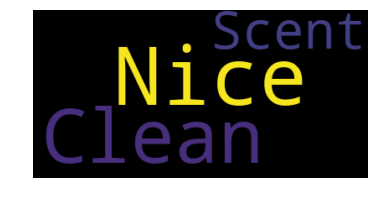

In [21]:
# Start with one review:
text = ratings.review_summary[190000]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
text = " ".join(review_text for review_text in ratings.review_text)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 93892300 words in the combination of all review.


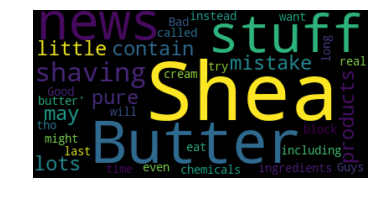

In [51]:
text = ratings.review_text[198501]
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

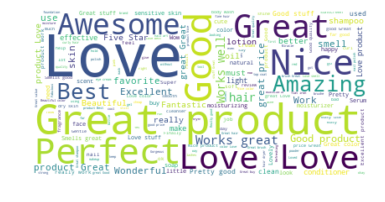

In [50]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["the", "of", "a", "an", "and","about",'one'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# EDA

In [24]:
new_df = ratings[["user_id", 'item_id', "score","review_summary"]]

In [25]:
new_df.drop_duplicates().score.value_counts()

5.0    114531
4.0     39741
3.0     22248
2.0     11456
1.0     10526
Name: score, dtype: int64

Text(0.5, 1.0, 'histogram of score_counts')

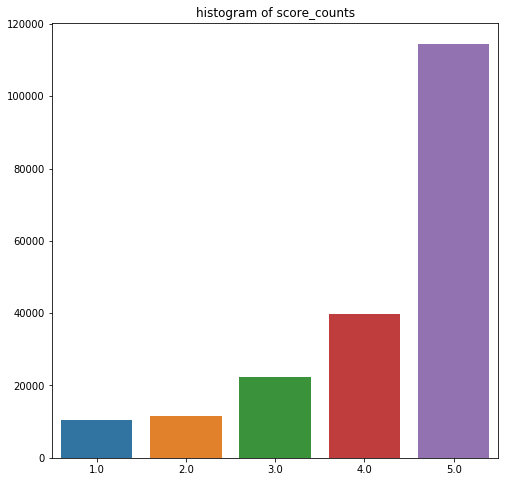

In [27]:
score_counts = new_df.drop_duplicates().score.value_counts()
plt.figure(figsize=(8,8))
sns.barplot(x = score_counts.index, y = score_counts.values)
plt.title('histogram of score_counts')

In [41]:
# sorted by score
good_reviews = new_df[(new_df["score"] >= 4)]
top_good_reviews= good_reviews.sort_values(by ='score',ascending=False)

In [43]:
top_good_reviews.head()

,user_id,item_id,score,review_summary
99580,18811,6683,5.0,I'm kind of in love with this company and thei...
121141,4343,8064,5.0,it smells like baby powder or talcum powder
121166,14395,8066,5.0,This product gets high praises from me
121165,10160,8066,5.0,Seems to be working.
121164,3610,8066,5.0,"Unbelievable, my dark spots and old acne marks..."


In [46]:
good_reviews.head(15)

,user_id,item_id,score,review_summary
2,14499,0,4.0,great quality
5,13792,0,5.0,Very nice palette!
12,2380,1,5.0,This works
14,6089,1,5.0,it works
16,17564,1,5.0,Did work for me
17,22008,1,4.0,excellent
19,4329,2,5.0,Love the smell of this!
20,16938,2,5.0,Happy
21,8277,2,5.0,Very good
22,8657,2,5.0,Lurrrrrrrrv.....


In [48]:
text = " ".join(review_summary for review_summary in good_reviews.review_summary)
print ("There are {} words in the combination of all reviews.".format(len(text)))

There are 3579158 words in the combination of all reviews.


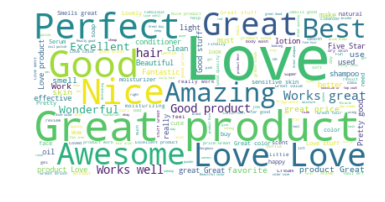

In [49]:
stopwords = set(STOPWORDS)
stopwords.update(["the", "of", "a", "an", "and","about",'one'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [89]:
bad_reviews_items = new_df[(new_df["score"] <= 3)]

In [90]:
bad_reviews_items.head()

,user_id,item_id,score,review_summary
0,5584,0,1.0,Don't waste your money
1,17504,0,3.0,OK Palette!
3,4157,0,2.0,Do not work on my face
4,13219,0,3.0,It's okay.
6,5704,0,1.0,smh!!!


In [60]:
bad_reviews.score.value_counts()

3.0    22248
2.0    11456
1.0    10526
Name: score, dtype: int64

In [96]:
bad_reviews = new_df[(new_df["item_id"]) & (new_df["score"] <= 3)]

In [97]:
bad_reviews.head(10)

,user_id,item_id,score,review_summary
8,15399,1,2.0,"no Lightening, no Brightening,......NOTHING"
9,11934,1,3.0,Its alright
10,20678,1,3.0,Mixed feelings.
11,14368,1,1.0,Nothing
13,20653,1,1.0,Does nothing
15,4754,1,2.0,burns
18,10618,1,3.0,weird smell
25,12024,3,3.0,fresh smell
29,9703,3,3.0,Love the smell but a shame it's not last as long
35,21672,5,2.0,Not impressed


In [98]:
bad_reviews.groupby(new_df['score'] <= 3 & new_df['item_id']).count()
# there are 14010 items out of the total 198502 items scores equal or lower than 3

,user_id,item_id,score,review_summary
False,8137,8137,8137,8137
True,14010,14010,14010,14010


In [99]:
text_bad_reviews = " ".join(review_summary for review_summary in bad_reviews.review_summary)
print ("There are {} words in the combination of all bad reviews.".format(len(text_bad_reviews)))

There are 545854 words in the combination of all bad reviews.


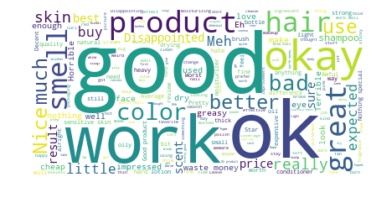

In [101]:
stopwords = set(STOPWORDS)
stopwords.update(["the", "of", "a", "an", "and","about",'one'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_bad_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()